# P&C Chain-Ladder Reserving Model

This notebook implements a basic Property & Casualty reserving model using the chain-ladder method. It follows a seven-step process to forecast ultimate claims and calculate the IBNR (Incurred But Not Reported) reserve.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

## Step 1 & 2: Data Collection, Preparation, and Triangle Compilation

We begin by defining the cumulative loss development triangle. In a real-world scenario, this data would be collected, cleaned, and aggregated. For this demonstration, we use a pre-compiled triangle.

- **Rows**: Accident Years
- **Columns**: Development Periods (in months)

In [6]:
data = {
    'accident_year': [2021, 2022, 2023, 2024],
    12: [10000, 12000, 15000, 18000],
    24: [17500, 20400, 27000, np.nan],
    36: [21000, 25500, np.nan, np.nan],
    48: [22050, np.nan, np.nan, np.nan]
}
loss_triangle = pd.DataFrame(data).set_index('accident_year')

print("Cumulative Loss Development Triangle (in thousands):")
loss_triangle

Cumulative Loss Development Triangle (in thousands):


,12,24,36,48
accident_year,,,,
2021,10000,17500.0,21000.0,22050.0
2022,12000,20400.0,25500.0,NaN
2023,15000,27000.0,NaN,NaN
2024,18000,NaN,NaN,NaN


### Visualization: Loss Development Triangle Heatmap

A heatmap helps visualize the growth of cumulative losses across accident years and development periods. The intensity of the color represents the magnitude of the losses.

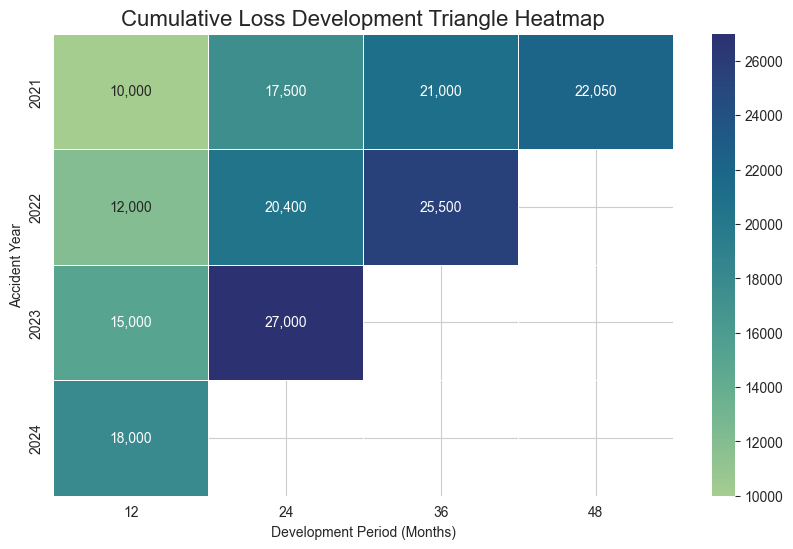

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(loss_triangle, annot=True, fmt=",.0f", cmap="crest", linewidths=.5)
plt.title('Cumulative Loss Development Triangle Heatmap', fontsize=16)
plt.xlabel('Development Period (Months)')
plt.ylabel('Accident Year')
plt.show()

## Step 3: Calculate Age-to-Age (LDF) Factors

We now calculate the Loss Development Factors (LDFs), also known as link ratios. These factors measure the growth of claims from one development period to the next.

**Formula**: `LDF = Cumulative Losses at Period(n) / Cumulative Losses at Period(n-1)`

In [8]:
ldf_triangle = pd.DataFrame(index=loss_triangle.index)
for i in range(len(loss_triangle.columns) - 1):
    col_name = f"{loss_triangle.columns[i]}-{loss_triangle.columns[i+1]}"
    ldf_triangle[col_name] = loss_triangle.iloc[:, i+1] / loss_triangle.iloc[:, i]

print("Calculated Age-to-Age Factors (LDFs):")
ldf_triangle

Calculated Age-to-Age Factors (LDFs):


,12-24,24-36,36-48
accident_year,,,
2021,1.75,1.20,1.05
2022,1.70,1.25,NaN
2023,1.80,NaN,NaN
2024,NaN,NaN,NaN


### Visualization: Age-to-Age Factors (LDFs)

This plot shows the calculated LDFs for each development period. It helps in identifying trends or volatility in claim development patterns over time. We also plot the selected average LDF for comparison.

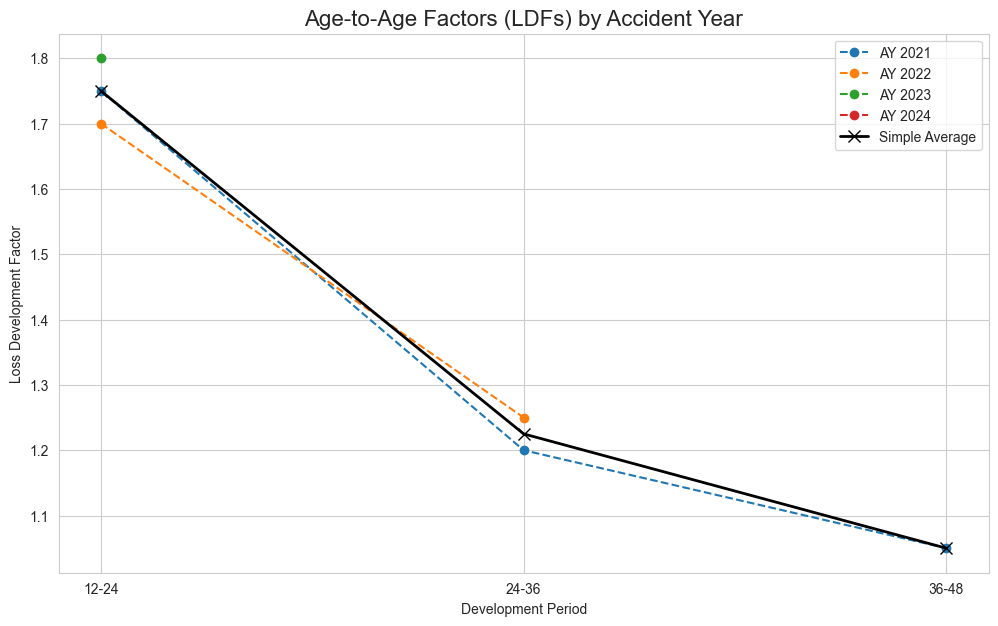

In [9]:
plt.figure(figsize=(12, 7))
for year in ldf_triangle.index:
    plt.plot(ldf_triangle.columns, ldf_triangle.loc[year], marker='o', linestyle='--', label=f'AY {year}')

# Plot the simple average for comparison
plt.plot(ldf_triangle.columns, ldf_triangle.mean(), marker='x', linestyle='-', color='black', linewidth=2, markersize=8, label='Simple Average')

plt.title('Age-to-Age Factors (LDFs) by Accident Year', fontsize=16)
plt.xlabel('Development Period')
plt.ylabel('Loss Development Factor')
plt.legend()
plt.show()

## Step 4: Select Claim Development Factors

Next, we select a single, representative LDF for each development column to be used for projections. For simplicity, we use the simple average. We also select a **tail factor** to project development beyond the observed periods.

In [10]:
# Calculate simple average for each LDF column
selected_ldfs = ldf_triangle.mean()

# Select a tail factor (this is a judgmental step)
tail_factor = 1.02
selected_ldfs['48-Ultimate'] = tail_factor

print("Selected Development Factors (Simple Average):")
selected_ldfs

Selected Development Factors (Simple Average):


12-24          1.750
24-36          1.225
36-48          1.050
48-Ultimate    1.020
dtype: float64

## Step 5: Calculate Cumulative Development Factors (CDFs)

The selected LDFs are multiplied together ("chained") to calculate the Cumulative Development Factors (CDFs). The CDF represents the total expected development from a given age to its ultimate settlement.

In [11]:
cdfs = pd.Series(index=selected_ldfs.index, dtype=float)
cdfs.iloc[-1] = selected_ldfs.iloc[-1] # The last CDF is the tail factor

# Calculate CDFs by working backward
for i in range(len(selected_ldfs) - 2, -1, -1):
    cdfs.iloc[i] = selected_ldfs.iloc[i] * cdfs.iloc[i+1]

print("Cumulative Development Factors (CDFs):")
cdfs

Cumulative Development Factors (CDFs):


12-24          2.295956
24-36          1.311975
36-48          1.071000
48-Ultimate    1.020000
dtype: float64

## Step 6: Project Ultimate Claims

We use the CDFs to project the ultimate loss amount for each accident year by multiplying the latest available cumulative loss by its corresponding CDF.

**Formula**: `Ultimate Loss = Latest Cumulative Loss * CDF`

In [12]:
# Get the latest available cumulative loss for each accident year (the diagonal)
latest_losses = loss_triangle.ffill(axis=1).iloc[:, -1]

# Create a results DataFrame
results = pd.DataFrame({
    'Latest Cumulative Loss': latest_losses,
    'Development Age': [48, 36, 24, 12] # Manually set for clarity
})

# Map the correct CDF to each accident year
age_to_cdf_map = {
    48: cdfs['48-Ultimate'],
    36: cdfs['36-48'],
    24: cdfs['24-36'],
    12: cdfs['12-24']
}
results['CDF'] = results['Development Age'].map(age_to_cdf_map)

# Calculate projected ultimate loss
results['Projected Ultimate Loss'] = results['Latest Cumulative Loss'] * results['CDF']

print("Projection of Ultimate Claims:")
results

Projection of Ultimate Claims:


,Latest Cumulative Loss,Development Age,CDF,Projected Ultimate Loss
accident_year,,,,
2021,22050.0,48,1.020000,22491.0000
2022,25500.0,36,1.071000,27310.5000
2023,27000.0,24,1.311975,35423.3250
2024,18000.0,12,2.295956,41327.2125


## Step 7: Calculate the IBNR Reserve

The final step is to calculate the IBNR reserve, which is the difference between the projected ultimate loss and the latest reported cumulative loss.

**Formula**: `IBNR Reserve = Projected Ultimate Loss - Latest Cumulative Loss`

In [13]:
results['IBNR Reserve'] = results['Projected Ultimate Loss'] - results['Latest Cumulative Loss']

print("Final IBNR Reserve Calculation:")
print(results)

# Calculate and display the total reserve
total_ibnr_reserve = results['IBNR Reserve'].sum()
print('\n' + '-'*40)
print(f"Total IBNR Reserve: {total_ibnr_reserve:,.0f}")
print('-'*40)

Final IBNR Reserve Calculation:
               Latest Cumulative Loss  Development Age       CDF  \
accident_year                                                      
2021                          22050.0               48  1.020000   
2022                          25500.0               36  1.071000   
2023                          27000.0               24  1.311975   
2024                          18000.0               12  2.295956   

               Projected Ultimate Loss  IBNR Reserve  
accident_year                                         
2021                        22491.0000      441.0000  
2022                        27310.5000     1810.5000  
2023                        35423.3250     8423.3250  
2024                        41327.2125    23327.2125  

----------------------------------------
Total IBNR Reserve: 34,002
----------------------------------------


### Visualization: Projected Ultimate Loss Components

This stacked bar chart shows the composition of the projected ultimate loss for each accident year, breaking it down into the latest known losses and the calculated IBNR reserve.

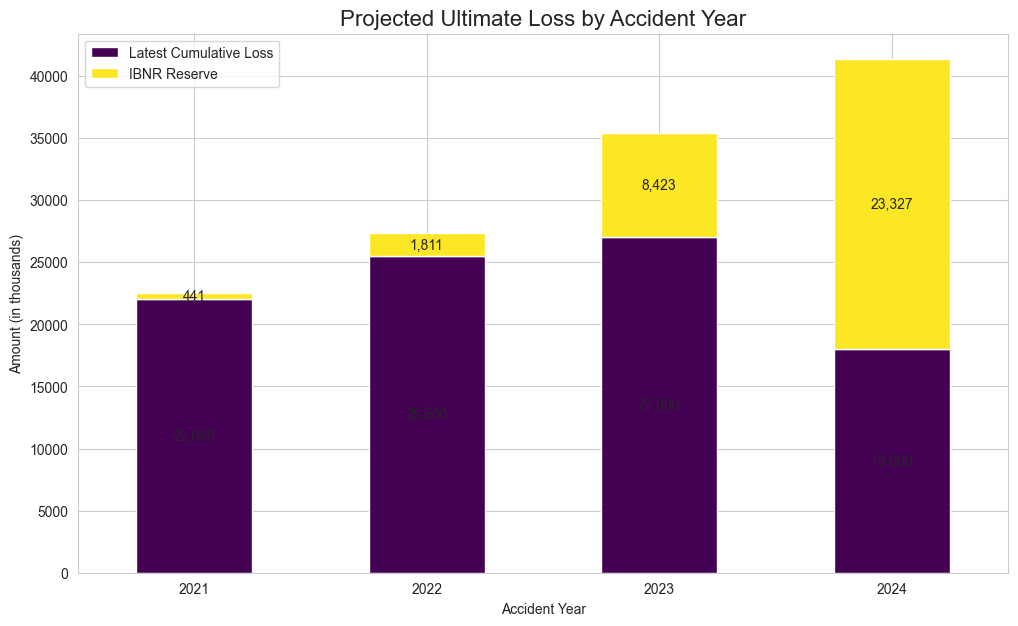

In [ ]:
results_plot = results[['Latest Cumulative Loss', 'IBNR Reserve']]

ax = results_plot.plot(kind='bar', stacked=True, figsize=(12, 7), color=['orange', 'skyblue'])

plt.title('Projected Ultimate Loss by Accident Year', fontsize=16)
plt.xlabel('Accident Year')
plt.ylabel('Amount (in thousands)')
plt.xticks(rotation=0)
plt.legend(['Latest Cumulative Loss', 'IBNR Reserve'])
()
# Add labels to the bars
for c in ax.containers:
    labels = [f'{v:,.0f}' for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type='center')

plt.show()